In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import cv2

from ultralytics import YOLO

from utils_MF import yolo_middle_fusion, draw_fused_boxes, run_middle_fusion_split, print_metrics
from utils_LF import evaluate_yolo_predictions, confusion_matrix_yolo, plot_confusion_matrix

ROOT = Path().resolve()

# Modelos entrenados
model_rgb = YOLO("runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
model_t   = YOLO("runs/detect/wildlife_t_v8n_cpu/weights/best.pt")

print("Modelos cargados:")
print("  RGB -> runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
print("  T   -> runs/detect/wildlife_t_v8n_cpu/weights/best.pt")

# Directorios de imágenes RGB / T
VAL_RGB_DIR  = ROOT / "data" / "format_rgb" / "images" / "val"
VAL_T_DIR    = ROOT / "data" / "format_t"   / "images" / "val"

TEST_RGB_DIR = ROOT / "data" / "format_rgb" / "images" / "test"
TEST_T_DIR   = ROOT / "data" / "format_t"   / "images" / "test"

# Directorios de salida para VAL
OUT_IMG_MF_VAL_DIR  = ROOT / "runs" / "middle_fusion" / "val"
OUT_PRED_MF_VAL_DIR = ROOT / "runs" / "middle_fusion" / "preds_val"

# Directorios de salida para TEST
OUT_IMG_MF_TEST_DIR  = ROOT / "runs" / "middle_fusion" / "test"
OUT_PRED_MF_TEST_DIR = ROOT / "runs" / "middle_fusion" / "preds_test"

for d in [OUT_IMG_MF_VAL_DIR, OUT_PRED_MF_VAL_DIR, OUT_IMG_MF_TEST_DIR, OUT_PRED_MF_TEST_DIR]:
    d.mkdir(parents=True, exist_ok=True)

class_names = {
    0: "Cow",
    1: "Deer",
    2: "Horse",
}

print("Dirs creados:")
print("  VAL  imgs :", OUT_IMG_MF_VAL_DIR)
print("  VAL  preds:", OUT_PRED_MF_VAL_DIR)
print("  TEST imgs :", OUT_IMG_MF_TEST_DIR)
print("  TEST preds:", OUT_PRED_MF_TEST_DIR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modelos cargados:
  RGB -> runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt
  T   -> runs/detect/wildlife_t_v8n_cpu/weights/best.pt
Dirs creados:
  VAL  imgs : C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs\middle_fusion\val
  VAL  preds: C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs\middle_fusion\preds_val
  TEST imgs : C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs\middle_fusion\test
  TEST preds: C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs\middle_fusion\preds_test


In [48]:
run_middle_fusion_split(
    model_rgb=model_rgb,
    model_t=model_t,
    class_names=class_names,
    rgb_dir=VAL_RGB_DIR,
    t_dir=VAL_T_DIR,
    out_img_dir=OUT_IMG_MF_VAL_DIR,
    out_pred_dir=OUT_PRED_MF_VAL_DIR,
    img_size=640,
)


Encontradas 64 imágenes RGB en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\data\format_rgb\images\val.
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0048.JPG -> img:020221_deer_pens_xt2_DJI_0048.JPG, preds:020221_deer_pens_xt2_DJI_0048.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0048.JPG -> img:020221_deer_pens_xt2_DJI_0048.JPG, preds:020221_deer_pens_xt2_DJI_0048.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0360.JPG -> img:020221_deer_pens_xt2_DJI_0360.JPG, preds:020221_deer_pens_xt2_DJI_0360.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0360.JPG -> img:020221_deer_pens_xt2_DJI_0360.JPG, preds:020221_deer_pens_xt2_DJI_0360.txt
[OK] Middle Fusion: 022521_DJI_0132.JPG -> img:022521_DJI_0132.JPG, preds:022521_DJI_0132.txt
[OK] Middle Fusion: 022521_DJI_0132.JPG -> img:022521_DJI_0132.JPG, preds:022521_DJI_0132.txt
[OK] Middle Fusion: 060421_DJI_0676.JPG -> img:060421_DJI_0676.JPG, preds:060421_DJI_0676.txt
[OK] Middle Fusion: 060421_DJI_0676.JPG -> img:060421_DJI_

In [49]:
run_middle_fusion_split(
    model_rgb=model_rgb,
    model_t=model_t,
    class_names=class_names,
    rgb_dir=TEST_RGB_DIR,
    t_dir=TEST_T_DIR,
    out_img_dir=OUT_IMG_MF_TEST_DIR,
    out_pred_dir=OUT_PRED_MF_TEST_DIR,
    img_size=640,
)


Encontradas 36 imágenes RGB en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\data\format_rgb\images\test.
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0316.JPG -> img:020221_deer_pens_xt2_DJI_0316.JPG, preds:020221_deer_pens_xt2_DJI_0316.txt
[OK] Middle Fusion: 020221_deer_pens_xt2_DJI_0316.JPG -> img:020221_deer_pens_xt2_DJI_0316.JPG, preds:020221_deer_pens_xt2_DJI_0316.txt
[OK] Middle Fusion: 071521_DeerPens_xt2_DJI_0468.JPG -> img:071521_DeerPens_xt2_DJI_0468.JPG, preds:071521_DeerPens_xt2_DJI_0468.txt
[OK] Middle Fusion: 071521_DeerPens_xt2_DJI_0468.JPG -> img:071521_DeerPens_xt2_DJI_0468.JPG, preds:071521_DeerPens_xt2_DJI_0468.txt
[OK] Middle Fusion: CA_DJI_0504.jpg -> img:CA_DJI_0504.jpg, preds:CA_DJI_0504.txt
[OK] Middle Fusion: CA_DJI_0504.jpg -> img:CA_DJI_0504.jpg, preds:CA_DJI_0504.txt
[OK] Middle Fusion: CA_DJI_0510.jpg -> img:CA_DJI_0510.jpg, preds:CA_DJI_0510.txt
[OK] Middle Fusion: CA_DJI_0510.jpg -> img:CA_DJI_0510.jpg, preds:CA_DJI_0510.txt
[OK] Middle Fusio

In [50]:
NUM_CLASSES = 3
CLASS_LABELS = ["Cow", "Deer", "Horse"]

PRED_MF_VAL_DIR = ROOT / "runs" / "middle_fusion" / "preds_val"
GT_VAL_DIR      = ROOT / "data" / "format_rgb" / "labels" / "val"

metrics_mf_val = evaluate_yolo_predictions(
    pred_dir=PRED_MF_VAL_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

metrics_mf_val


{'AP_per_class': [np.float64(0.920677022915462),
  np.float64(0.867969386655121),
  np.float64(0.9469969684649766)],
 'mAP': 0.9118811260118532,
 'TP': np.int64(90),
 'FP': np.int64(41),
 'FN': np.int64(4),
 'Precision': np.float64(0.6870229007581143),
 'Recall': np.float64(0.9574468085004526),
 'F1': np.float64(0.7999999995064099)}

In [51]:
PRED_MF_TEST_DIR = ROOT / "runs" / "middle_fusion" / "preds_test"
GT_TEST_DIR      = ROOT / "data" / "format_rgb" / "labels" / "test"

metrics_mf_test = evaluate_yolo_predictions(
    pred_dir=PRED_MF_TEST_DIR,
    gt_dir=GT_TEST_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

metrics_mf_test


{'AP_per_class': [np.float64(0.9631409427391309),
  np.float64(0.9999999993333333),
  np.float64(0.9999999998181818)],
 'mAP': 0.987713647296882,
 'TP': np.int64(47),
 'FP': np.int64(16),
 'FN': np.int64(0),
 'Precision': np.float64(0.7460317460199043),
 'Recall': np.float64(0.9999999999787235),
 'F1': np.float64(0.854545454040496)}

In [52]:
print_metrics("Middle Fusion (VAL)", metrics_mf_val)
print_metrics("Middle Fusion (TEST)", metrics_mf_test)


Middle Fusion (VAL) @ IoU 0.5
-------------------------------
mAP:       0.9118811260118532
Precision: 0.6870229007581143
Recall:    0.9574468085004526
F1:        0.7999999995064099
AP por clase: [np.float64(0.920677022915462), np.float64(0.867969386655121), np.float64(0.9469969684649766)]
Middle Fusion (TEST) @ IoU 0.5
--------------------------------
mAP:       0.987713647296882
Precision: 0.7460317460199043
Recall:    0.9999999999787235
F1:        0.854545454040496
AP por clase: [np.float64(0.9631409427391309), np.float64(0.9999999993333333), np.float64(0.9999999998181818)]


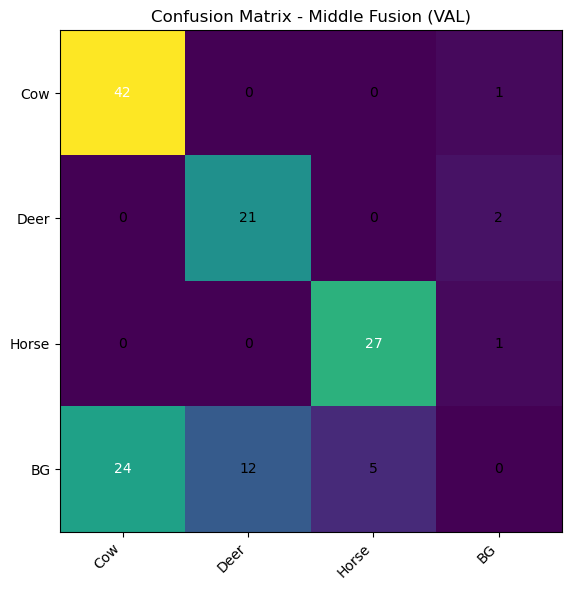

In [53]:
PRED_MF_VAL_DIR = ROOT / "runs" / "middle_fusion" / "preds_val"
GT_VAL_DIR      = ROOT / "data" / "format_rgb" / "labels" / "val"

cm_mf_val = confusion_matrix_yolo(
    pred_dir=PRED_MF_VAL_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

labels_cm = CLASS_LABELS + ["BG"]  # Background como columna extra

plot_confusion_matrix(cm_mf_val, labels_cm, title="Confusion Matrix - Middle Fusion (VAL)")


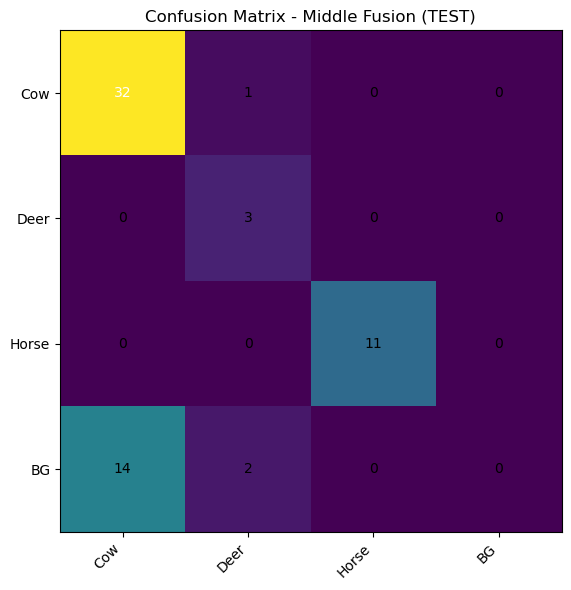

In [54]:
PRED_MF_TEST_DIR = ROOT / "runs" / "middle_fusion" / "preds_test"
GT_TEST_DIR      = ROOT / "data" / "format_rgb" / "labels" / "test"

cm_mf_test = confusion_matrix_yolo(
    pred_dir=PRED_MF_TEST_DIR,
    gt_dir=GT_TEST_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

labels_cm = CLASS_LABELS + ["BG"]

plot_confusion_matrix(cm_mf_test, labels_cm, title="Confusion Matrix - Middle Fusion (TEST)")
